#**Implementacion TinyGPT**

##**Nombre:** Eduardo Antonio Echeverria Echeverria
##**No. SIU:** a1516
##**eMail**: edwardminus1db@gmail.com

## Tareas

Usando TinyGPT debes implementar las siguientes modificaciones:
...

## Arquitectura
- Convertir TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.

## ¿Qué esperar?

- Comprender en profundidad la implementación de un modelo GPT.
- Implementar una capa MoE para crear un modelo GPT de vanguardia.
- Explorar algoritmos de decodificación para generación de texto.

### NOTA

La tokenización está fuera de alcance; usaremos un tokenizador por caracteres, sencillo pero ineficiente.

## Descargamos libreria 'trainer.py'

Al utilizar un Colab, utilicé la funcionalidad de Google Colab para subir archivos. Luego importé la libreria desde el directorio local del Colab.


In [1]:
from google.colab import files
files.upload()

Saving trainer.py to trainer.py


{'trainer.py': b'"""\ntrainer\n\nAuthor: Abraham Rodriguez \\n\n\nCreationDate: 24/5/2023 \nUpdateDate: 1/6/2025\n\nThis module provides utilities for training PyTorch models, including early stopping,\ncheckpointing, mixed precision support, and training/evaluation loops.\n\nThis module is heavily inspired on Huggingface\'s Trainer/Accelerate and Pytorch Lightning, for relevant docs read:\n- https://docs.pytorch.org/docs/stable/amp.html\n- https://huggingface.co/docs/accelerate/usage_guides/gradient_accumulation\n- https://lightning.ai/docs/pytorch/stable/advanced/training_tricks.html\n- https://pytorch-lightning.readthedocs.io/en/1.5.10/advanced/training_tricks.html\n- https://docs.pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html\n- https://lightning.ai/docs/pytorch/1.6.5/common/checkpointing.html\n"""\nimport copy\nimport numpy as np\nimport torch\nfrom torch.utils.data.dataloader import DataLoader\nfrom tqdm import tqdm\nimport os\n\nimport warnings\nimport fun

In [2]:
!ls

sample_data  trainer.py


In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import Optional, List, Type
import httpx

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from trainer import Trainer
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

## Descargamos el Dataset

In [4]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
text = response.text

text = text[:100_000]  # Using 100k characters for speedup
print(text)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



## Implementamos Character-based *encoding*

In [5]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
print(f"StoI:\n{stoi}")
print(f"ItoS:\n{itos}")

def encode(s):
    return [stoi[c] for c in s]

def decode(l):
    return ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)

# Train/test split
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

StoI:
{'\n': 0, ' ': 1, '!': 2, '&': 3, "'": 4, ',': 5, '-': 6, '.': 7, ':': 8, ';': 9, '?': 10, 'A': 11, 'B': 12, 'C': 13, 'D': 14, 'E': 15, 'F': 16, 'G': 17, 'H': 18, 'I': 19, 'J': 20, 'K': 21, 'L': 22, 'M': 23, 'N': 24, 'O': 25, 'P': 26, 'Q': 27, 'R': 28, 'S': 29, 'T': 30, 'U': 31, 'V': 32, 'W': 33, 'Y': 34, 'a': 35, 'b': 36, 'c': 37, 'd': 38, 'e': 39, 'f': 40, 'g': 41, 'h': 42, 'i': 43, 'j': 44, 'k': 45, 'l': 46, 'm': 47, 'n': 48, 'o': 49, 'p': 50, 'q': 51, 'r': 52, 's': 53, 't': 54, 'u': 55, 'v': 56, 'w': 57, 'x': 58, 'y': 59, 'z': 60}
ItoS:
{0: '\n', 1: ' ', 2: '!', 3: '&', 4: "'", 5: ',', 6: '-', 7: '.', 8: ':', 9: ';', 10: '?', 11: 'A', 12: 'B', 13: 'C', 14: 'D', 15: 'E', 16: 'F', 17: 'G', 18: 'H', 19: 'I', 20: 'J', 21: 'K', 22: 'L', 23: 'M', 24: 'N', 25: 'O', 26: 'P', 27: 'Q', 28: 'R', 29: 'S', 30: 'T', 31: 'U', 32: 'V', 33: 'W', 34: 'Y', 35: 'a', 36: 'b', 37: 'c', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'i', 44: 'j', 45: 'k', 46: 'l', 47: 'm', 48: 'n', 49: 'o', 50: '

## Definimos los Dataloaders

In [6]:
class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

## Definimos la Configuracion GPT

In [7]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)

@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 8
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 32, 'batch_size': 8, 'n_embd': 64, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 61, 'bias': True, 'ff_class': None, 'moe': None}


In [8]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

train_loader = DataLoader(train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8, # if using mps set num_workers as 0.
                        )
val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8,
                        )

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

        # Combined QKV projection
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

        # Scaled dot-product attention
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [11]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

## Implementamos la Arquitectura TinyGPT

In [12]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits

## Se define la funcion de inferencia "Generate"

In [13]:
@torch.no_grad()
def generate(prompt: str, max_new_tokens: int = 100, use_cache: bool = True):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

## Implementamos el Setup

In [14]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
m = TinyGPT(config).to(device)
model = torch.compile(m)

print(f"Device: {device}")

Device: cuda


In [15]:
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

## Entrenamos el modelo

In [16]:
# Trainer instance
trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Training
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

print("Training complete.")

  0%|          | 0/11246 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
W0818 23:24:05.999000 286 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_induc

Epoch 1 training loss: 2.1026


  0%|          | 0/1246 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val_loss 2.12328: 100%|██████████| 1246/1246 [00:09<00:00, 134.41it/s]


Epoch 1 validation loss: 2.0551


loss 2.09437: 100%|██████████| 11246/11246 [03:03<00:00, 61.13it/s]


Epoch 2 training loss: 2.0890


val_loss 2.12328: 100%|██████████| 1246/1246 [00:08<00:00, 138.57it/s]

Epoch 2 validation loss: 2.0551
Training complete.


## Realizamos una prueba

In [17]:
generate("To be", max_new_tokens=100,use_cache=True)

'To bepore Comey!\n\nHens?\n\nWhell ICORUS:\nToull gat ve.\n\nBoy whathe Meret Mey, tretisens whior, soup:\nA de c'

# Tarea I

Usando TinyGPT debes implementar las siguientes modificaciones:


## Inferencia: modifica la función `generate` para:
- Decodificación *greedy* (seleccionar el token con mayor probabilidad).
- Muestreo por temperatura.
- Muestreo *top‑k* o *top‑p*.

### Referencias
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)



In [19]:
@torch.no_grad()
def generateV2(
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: Optional[int] = None,
    top_p: Optional[float] = None,
    greedy: bool = False,
):

    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)
        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        logits = logits[:, -1, :]

        # Aplicamos Temperature scaling
        if temperature != 1.0:
            logits = logits / temperature

        # Implementamos Greedy decoding
        if greedy:
            next_token = torch.argmax(logits, dim=-1, keepdim=True)

        else:
            probs = F.softmax(logits, dim=-1)

            # Top-k sampling
            if top_k is not None:
                values, indices = torch.topk(probs, top_k)
                probs = torch.zeros_like(probs).scatter_(1, indices, values)
                probs = probs / probs.sum(dim=-1, keepdim=True)

            # Top-p (nucleus) sampling
            if top_p is not None:
                sorted_probs, sorted_indices = torch.sort(probs, descending=True)
                cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

                mask = cumulative_probs > top_p
                mask[..., 1:] = mask[..., :-1].clone()
                mask[..., 0] = False

                sorted_probs[mask] = 0.0
                probs = torch.zeros_like(probs).scatter_(1, sorted_indices, sorted_probs)
                probs = probs / probs.sum(dim=-1, keepdim=True)

            next_token = torch.multinomial(probs, num_samples=1)

        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())


## Comparar `generate` vs `generateV2`

In [34]:
result_1 = generate("To be", max_new_tokens=100,use_cache=True)

# Comparamos con la funcion GenerateV2
result_2 = generateV2("To be", max_new_tokens=100,use_cache=True)

# Realizamos la comparacion utilizando Greedy Decoding
result_3 = generateV2("To be", max_new_tokens=50, greedy=True)

# Realizamos la comparacion utilizando Temperature Sampling
result_4 = generateV2("To be", max_new_tokens=50, temperature=0.7)

# Realizamos la comparacion utilizando Top-K Sampling
result_5 = generateV2("To be", max_new_tokens=50, top_k=50)

# Realizamos la comparacion utilizando Top-p (nucleus) sampling:
result_6 = generateV2("To be", max_new_tokens=50, top_p=0.9)

# Realizamos la comparacion utilizando una combinacion de Temperature + Top-K:
result_7 = generateV2("To be", max_new_tokens=50, temperature=0.8, top_k=40)


print(f"Result 1 (Funcion Original):\n{result_1}\n")
print(f"Result 2 (Funcion GenerateV2):\n{result_2}\n")
print(f"Result 3 (Funcion GenerateV2 con Greedy Decoding):\n{result_3}\n")
print(f"Result 4 (Funcion GenerateV2 Con Temperature Sampling):\n{result_4}\n")
print(f"Result 5 (Funcion GenerateV2 con Top-K Sampling):\n{result_5}\n")
print(f"Result 6 (Funcion GenerateV2 con Top-P Sampling):\n{result_6}\n")
print(f"Result 7 (Funcion GenerateV2 con una combinacion de Temperarture + Top-K):\n{result_7}\n")

Result 1 (Funcion Original):
To be maveind mand bakeflusertiusecut woonc!, st gredout ve
Comet nariper?

BRIUS:
Toust prencties:
If ve

Result 2 (Funcion GenerateV2):
To bely wiur ga:
MIUM: tus thare deato tis.

The mudst your hauphe cok, the in thecon thoun fatvo asce 'n

Result 3 (Funcion GenerateV2 con Greedy Decoding):
To be the the the the the the the the the the the the t

Result 4 (Funcion GenerateV2 Con Temperature Sampling):
To beourst notur Maret the aly my the beas at minct an 

Result 5 (Funcion GenerateV2 con Top-K Sampling):
To bere sthe her?

OMANUS:
Yould cichmell? wor obe Meed

Result 6 (Funcion GenerateV2 con Top-P Sampling):
To best
Anotin or, you the sit
He gand mond blang.

COR

Result 7 (Funcion GenerateV2 con una combinacion de Temperarture + Top-K):
To beard the o tus-
And wis swirncin the pos in the wou



## Tarea II
- Convierte TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.

In [23]:
class Expert(nn.Module):
    """
    One MLP expert.
    """
    def __init__(self, config: GPTConfig) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class Gate(nn.Module):
    """
    Gating network: predicts per-token logits over experts.
    """
    def __init__(self, config: GPTConfig):
        super().__init__()
        assert config.moe is not None, "Gate requires config.moe"
        self.proj = nn.Linear(config.n_embd, config.moe.num_experts)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.proj(x)

In [24]:
class MoELayer(nn.Module):
    """
    Mixture-of-Experts FFN with top-k routing.
    """
    def __init__(self, experts: List[nn.Module], gate: nn.Module, config: GPTConfig):
        super().__init__()
        assert config.moe is not None, "MoELayer requires config.moe"
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.config = config
        self.num_experts = config.moe.num_experts
        self.top_k = config.moe.num_experts_per_token
        assert 1 <= self.top_k <= self.num_experts, "Invalid num_experts_per_token"

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, T, C)
        returns: (B, T, C)
        """
        B, T, C = x.shape
        E = self.num_experts
        K = self.top_k

        logits = self.gate(x)                      # (B, T, E)
        probs  = F.softmax(logits, dim=-1)         # (B, T, E)

        topk_probs, topk_idx = torch.topk(probs, k=K, dim=-1)  # both (B, T, K)

        out_k = torch.zeros(B, T, K, C, device=x.device, dtype=x.dtype)

        x_expanded = x.unsqueeze(2).expand(B, T, K, C)

        for e, expert in enumerate(self.experts):
            mask_e = (topk_idx == e)  # bool (B, T, K)
            if not mask_e.any():
                continue

            x_e = x_expanded[mask_e]  # (N, C)
            y_e = expert(x_e)         # (N, C)

            w_e = topk_probs[mask_e].unsqueeze(-1)  # (N, 1)
            y_e = y_e * w_e                          # (N, C)

            out_k[mask_e] = out_k[mask_e] + y_e

        out = out_k.sum(dim=2)  # (B, T, C)
        return out

In [25]:
class MoEFFN(nn.Module):
    """
    Wrapper so you can plug MoE in via config.ff_class.
    """
    def __init__(self, config: GPTConfig):
        super().__init__()
        assert config.moe is not None, "MoEFFN requires config.moe"
        experts = [Expert(config) for _ in range(config.moe.num_experts)]
        gate = Gate(config)
        self.moe = MoELayer(experts=experts, gate=gate, config=config)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.moe(x)


## Agregando MoE a la configuracion

In [26]:
config.moe = MoEArgs(num_experts=4, num_experts_per_token=2)
config.ff_class = MoEFFN

## Entrenando TinyGPT-MoE

In [27]:
m_moe = TinyGPT(config).to(device)
model_moe = torch.compile(m_moe)

In [28]:
optimizer = AdamW(model_moe.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

In [29]:
# Trainer instance
trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500,
)
# Training
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

print("Training complete.")

  0%|          | 0/11246 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
loss 1.99583: 100%|██████████| 11246/11246 [06:16<00:00, 29.84it/s]


Epoch 1 training loss: 2.0649


  0%|          | 0/1246 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val_loss 1.94089: 100%|██████████| 1246/1246 [00:15<00:00, 81.34it/s]


Epoch 1 validation loss: 1.9900


  0%|          | 0/11246 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
loss 2.06254: 100%|██████████| 11246/11246 [06:25<00:00, 29.21it/s]


Epoch 2 training loss: 2.0451


val_loss 1.94089: 100%|██████████| 1246/1246 [00:15<00:00, 79.62it/s]

Epoch 2 validation loss: 1.9900
Training complete.


## Visualización de la atención

Como sabemos, un GPT tiene la tarea de completar texto; veamos los mapas de atención generados por un modelo preentrenado

In [30]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

    # Run forward with return_weights=True
    logits, all_weights = model(idx, return_weights=True)

    # all_weights is a list of length n_layers
    # each element: shape (n_heads, batch_size, seq_len, seq_len)
    # We'll visualize the first batch element only

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()

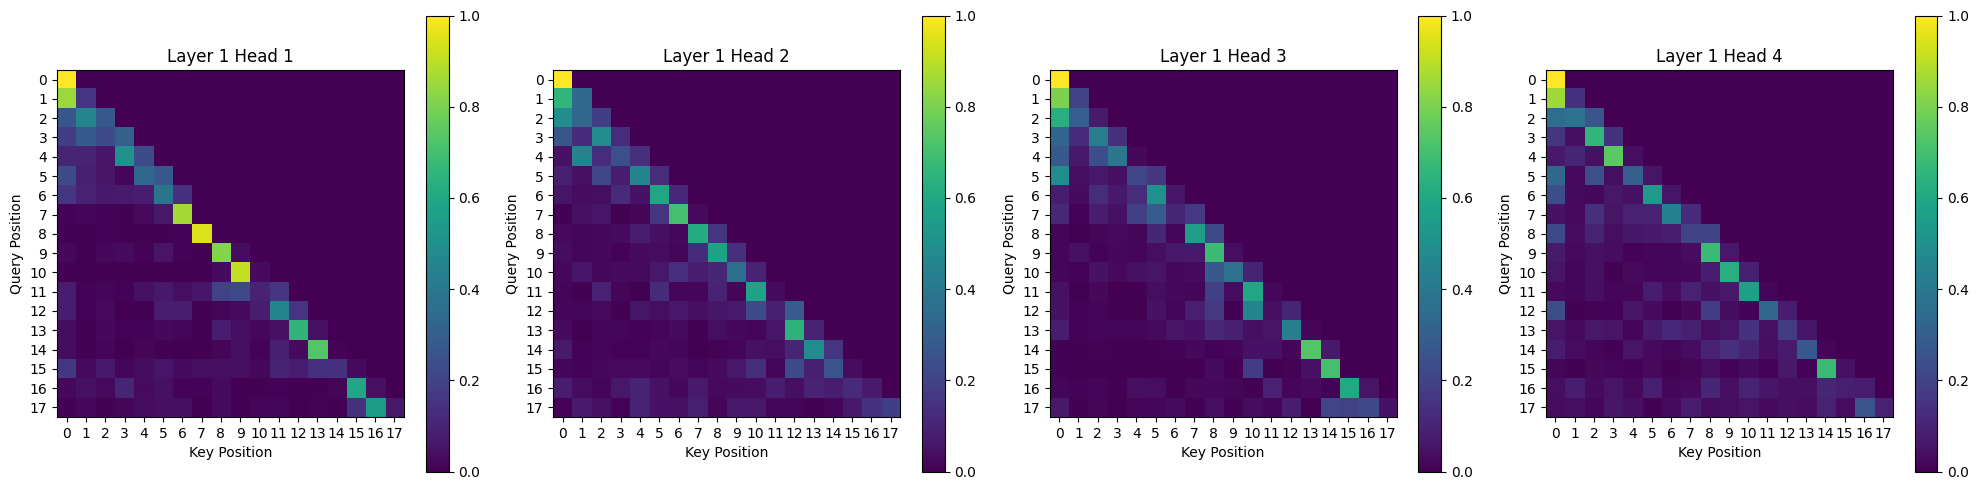

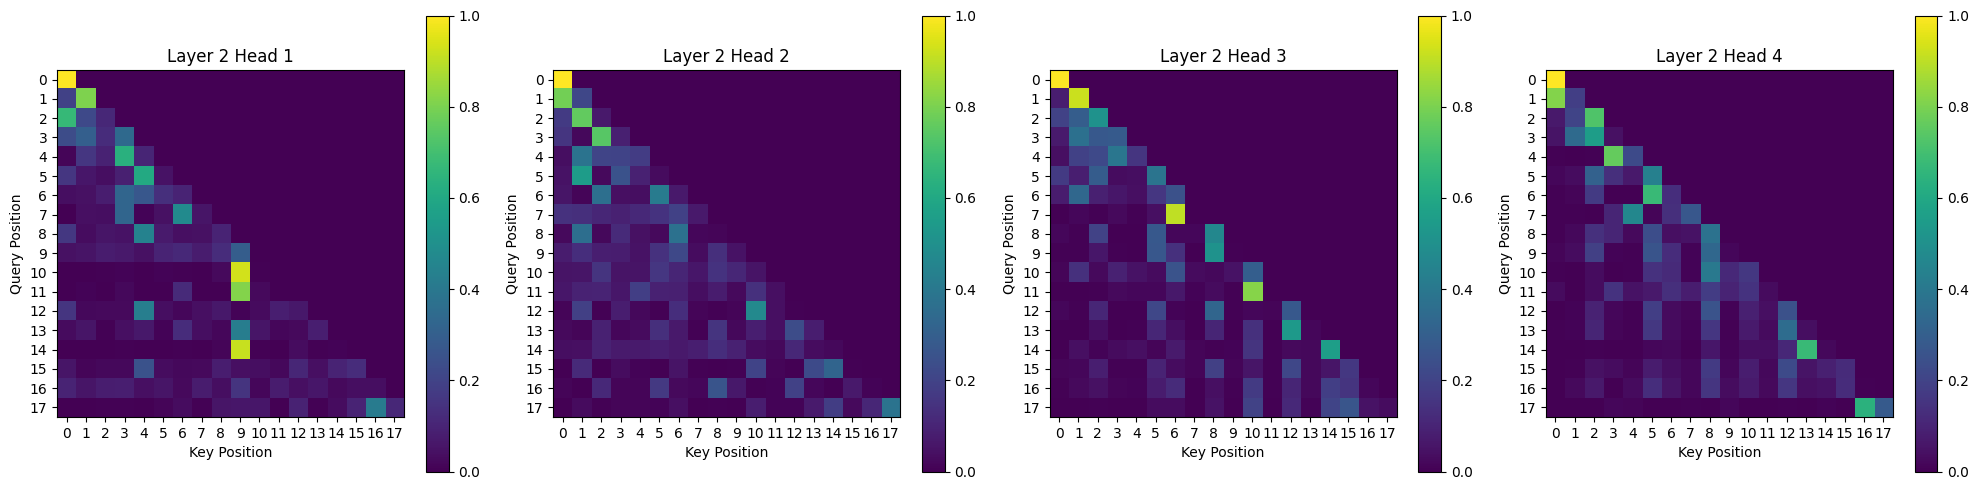

In [31]:
prompt = "To be or not to be"
visualize_attention(model, prompt)

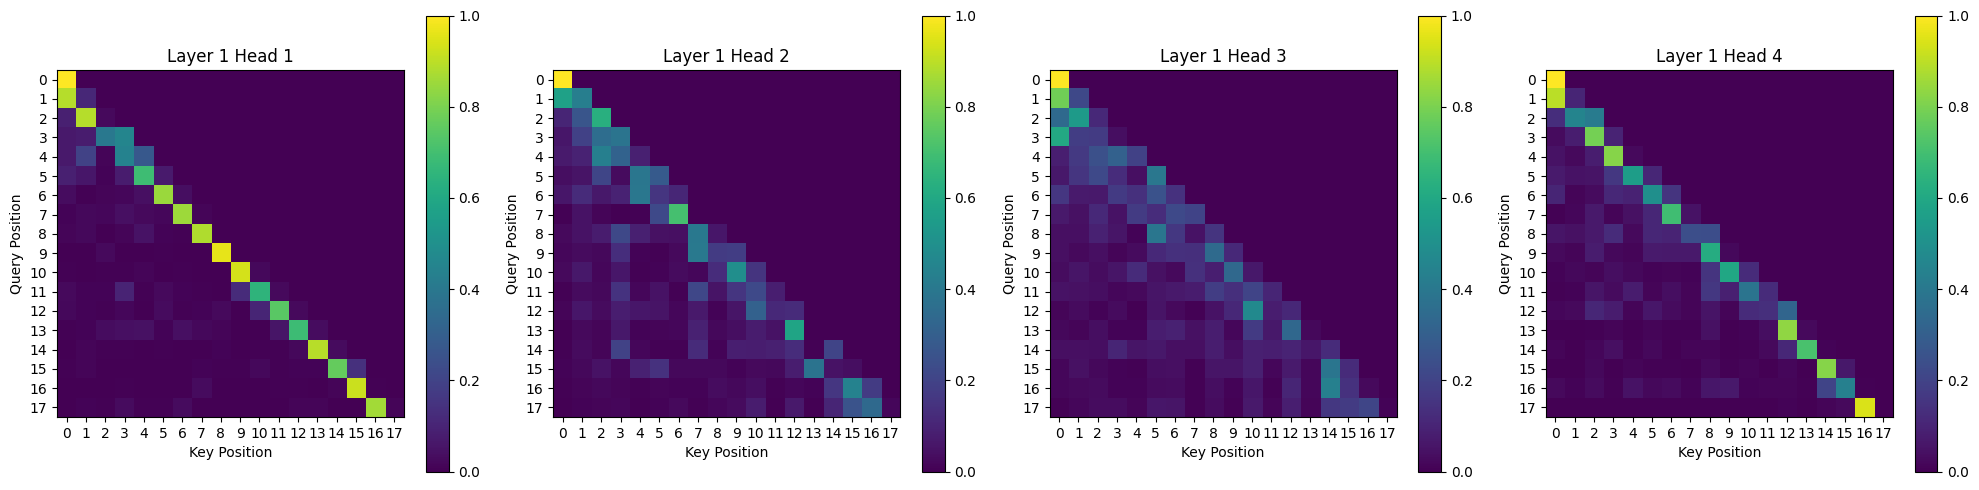

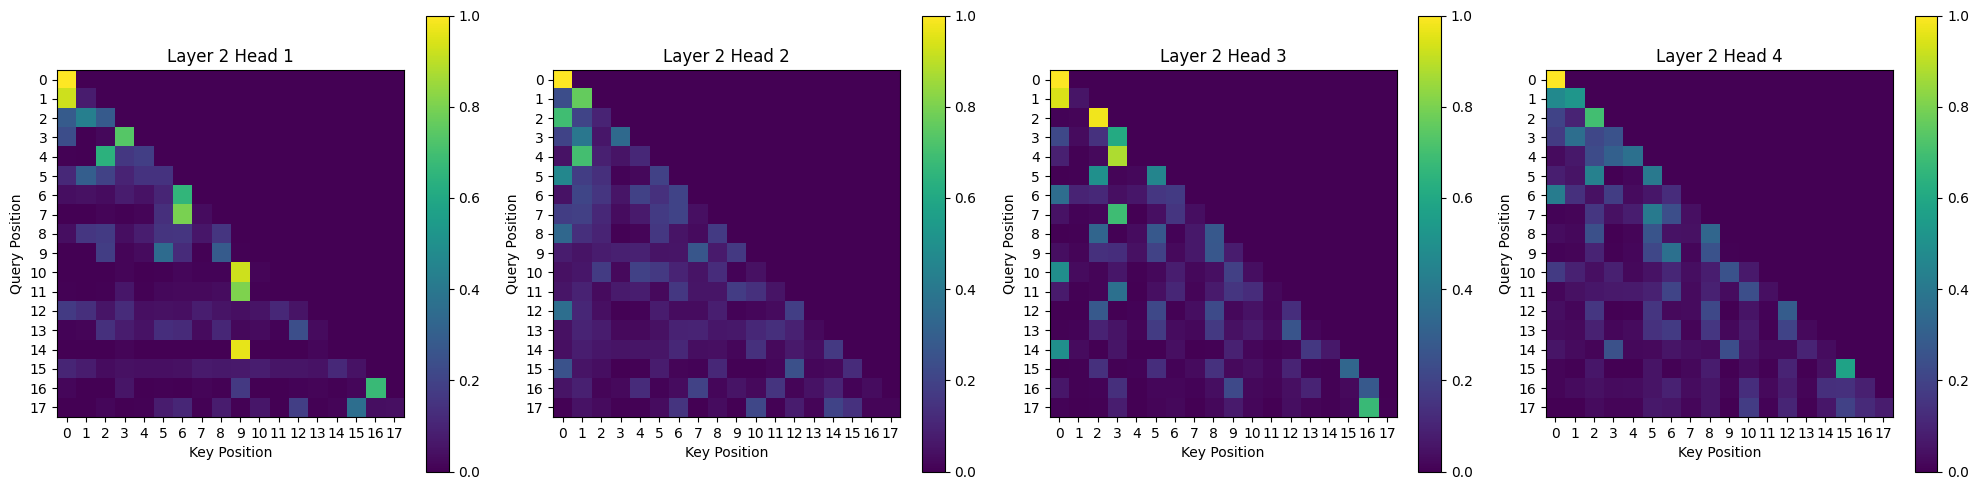

In [32]:
prompt = "To be or not to be"
visualize_attention(model_moe, prompt)

# Conclusiones

## Tarea I
Para esta tarea partimos de la función “Generate”, la cual en principio genera texto incomprensible.
A continuación se procedió a refactorizar la función anterior para desarrollar la nueva función “GenerateV2” la cual implementa las caracteristicas de Greedy Decore, Tempereature Sampling y Top-K/Top-P sampling.

Al ir modificando los parametros correspondientes a las caracteristicas introducidas, podemos apreciar que el resultado, si bien va cambiando con cada prueba continua entregando texto incomprensible. Quizas la prueba que devolvio un resultado un poco mas consistente es la prueba 3, utilizando el GReedy Decoding, en donde el resultado es "To be the the the the the the..." el cual por lo menos conserva una palabra correcta y consistente, aunque luego la repite una y otra vez.

Me llamo la atencion el hecho que al ir realizando mas pruebas, pude observar que el texto de los otros resultados iba cambiando, sin embargo el resultado de la prueba con Greedy Decoding siempre entrego el mismo resultado. Estuve investigando un poco la razon de este comportamiento en Greedy Decoding y por lo que pude ver, esto se debe a que el modelo cae en un bucle de alta probabilidad que hace que repita la misma palabra una y otra vez. Sin el suficiente entrenamiento, el modelo no sabe como salir de este bucle.

En general, los resultados de texto incoherente se estan produciendo porque tenemos un modelo pequeño con poca capacidad y porque estamos utilizando pocas epocas de entrenamiento.

Para mejoras futuras, pienso que seria interesante incrementar el numero de epocas dado que entiendo que los transformers puedenllegar a requerir muchos mas entrenamientos para aprender una estructura coherente.

## Tarea II

Se pudo implementar de manera exitosa la arquitectura TinyGPT asociándola con el mecanismo de Mixture-of-Experts (MoE). Para realizar esta implementacion fue necesario en primer lugar la capa de FeedForward standard con una capa Gated.

El entrenamiento del modelo funciono sin mayores inconvenientes, con lo que se pudo demostrar que el mecanismo MpE puede se integrado exitosamente en modelos GPT de pequeña escala.

Se pudo observar tambien que implementar MoE mejora la capacidad del modelo sin incrementar linealmente el costo computacional. Sin embargo es posible que no se este balancendo de forma eficinete la carga en los expertos.

Para futuras mejoras, se puede ir variando el numero de expertos y tambien agregar mecanismos de balanceo de carga (load-balancing loss) para mejorar un ruteo mas parejo entre los expertos .